In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math
import os
from statistics import mean
import notebook_functions

In [2]:
def calculate_ellipse_from_mask(binary_mask):
    mask = binary_mask.astype(np.int32)
    y_indices, x_indices = np.indices(mask.shape)
    positive_pixels = mask == 255
    result_x = x_indices[positive_pixels]
    result_y = y_indices[positive_pixels]
    n = len(result_x)

    sx = np.sum(result_x)
    cx = sx / len(result_x)
    sxx = np.sum(np.square(result_x))

    sy = np.sum(result_y)
    cy = sy / len(result_y)
    syy = np.sum(np.square(result_y))

    mult_list = [x * y for x, y in zip(result_x, result_y)]
    sxy = np.sum(mult_list)

    sigma_x2 = (sxx / n) - cx ** 2
    sigma_y2 = (syy / n) - cy ** 2
    sigma_xy = (sxy / n) - (cx * cy)

    cov_matrix = [[sigma_x2, sigma_xy], [sigma_xy, sigma_y2]]
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

    direction_a = eigenvectors[0] / np.linalg.norm(eigenvectors[0])
    direction_b = eigenvectors[1] / np.linalg.norm(eigenvectors[1])

    a = int(2 * (math.sqrt(abs(eigenvalues[0]))))  # semi major axis of projected ellipse
    b = int(2 * (math.sqrt(abs(eigenvalues[1]))))  # semi minor axis of projected ellipse

    return [a, b], [int(cx), int(cy)], [direction_a, direction_b] ,[*eigenvectors],


In [3]:
def draw_axes(img, img_ellipse):
    axes, center, direction, _ = img_ellipse
    a, b = axes
    direction_a, direction_b = direction

    print(a, b, center, direction_a, direction_b)

    end_point_a = (int(center[0] + a * direction_a[0]), int(center[1] + a * direction_a[1]))
    end_point_b = (int(center[0] + b * direction_b[0]), int(center[1] + b * direction_b[1]))

    font = cv2.FONT_HERSHEY_COMPLEX_SMALL
    font_scale = 1
    font_color = (255, 0, 0)  # Red color in BGR format
    thickness = 2

    major_letter = (
        int((center[0] + a * direction_a[0])),
        int((center[1] + a * direction_a[1]))
    )
    minor_letter = (
        int((center[0] + b * direction_b[0])),
        int((center[1] + b * direction_b[1]))
    )

    cv2.line(img, center, end_point_a, (0, 255, 0), 2)
    cv2.line(img, center, end_point_b, (0, 255, 0), 2)
    cv2.putText(img, "a", major_letter, font, font_scale, font_color, thickness, cv2.LINE_AA)
    cv2.putText(img, "b", minor_letter, font, font_scale, font_color, thickness, cv2.LINE_AA)


In [4]:
# CALCULATE THE NEXT ANGLE IF NEEDED
def angle_estimation(index_view):
    if oblate_angles[index_view] != -1: return oblate_angles[index_view]   # Return if already calculated in another cycle

    #Spheroid values
    A, B = oblate_spheroid
    b_curr = axe_b_all_views[index_view]
    fruit_rot = 'downwards'

    curr_cos_theta = math.sqrt((pow(b_curr, 2) - pow(B, 2))/(pow(A, 2) - pow(B, 2)))

    curr_theta_pos = np.degrees(np.arccos(curr_cos_theta))
    curr_theta_neg = np.degrees(-np.arccos(curr_cos_theta))
    current_view_angles = (curr_theta_pos, curr_theta_neg)

    rotation_per_view = 360 / len(axe_b_all_views) - 5
    correct_theta = lambda ascending_sequence: current_view_angles[0] if ascending_sequence and (fruit_rot == 'downwards') or (not ascending_sequence) and (fruit_rot == 'upwards') else current_view_angles[1]

    # Second ambiguity
    if 0 <= abs(current_view_angles[0]) <= rotation_per_view or abs(90 - rotation_per_view) <= abs(current_view_angles[0]) >= 0:   # Value calculated is in range or a local extrema
        if index_view < len(image_files) - 1:
            temp_correct_theta_value = correct_theta(get_trend_for_view(index_view, 0))
            oblate_angles[index_view] = temp_correct_theta_value
            next_view_angle = angle_estimation(index_view + 1)
            if next_view_angle in [0.0, 90.0, -90.0] or oblate_angles[index_view - 1] in [0.0, 90.0, -90.0]:
                theta = correct_theta(get_trend_for_view(index_view, 0))
            else:
                theta = choose_smooth_angle(oblate_angles[index_view - 1])
        else:
            theta = correct_theta(get_trend_for_view(index_view, 0))
    else:
        theta = correct_theta(get_trend_for_view(index_view, 0))

    oblate_angles[index_view] = theta
    return theta

In [5]:
def get_trend_for_view(index_view, direction = 0, step = 0):
    b_axes = prev_post_values_b(index_view, axe_b_all_views, step, direction)  # Try first with direction 0, in other recursions does direction 1 - forward
    trend = estimate_b_axe_trend(b_axes)
    if trend is None:
        return get_trend_for_view(index_view, 1, step + 1)
    else:
        return trend


In [6]:
def estimate_b_axe_trend(b_axes):
    mean_seq = mean(b_axes)
    if b_axes[0] < mean_seq < b_axes[-1]:
        return True   # "Ascending"
    elif b_axes[0] > mean_seq > b_axes[-1]:
        return False  # "Descending"
    else:
        return None   # No clear trend

In [7]:
def prev_post_values_b(current_b_index, b_list, steps, direction = 0):
    enlarged_b_list = [*b_list, *b_list]
    enlarged_index = current_b_index + len(b_list) - 1 if current_b_index < (len(b_list) / 2) else current_b_index
    total_steps = 3 + steps

    if direction < 0:
        b_axes = enlarged_b_list[(enlarged_index - total_steps) : enlarged_index]
    elif direction > 0:
        b_axes = enlarged_b_list[enlarged_index : (enlarged_index + total_steps)]
    else:
        b_axes = enlarged_b_list[enlarged_index - 2 : enlarged_index + 2]
    return b_axes

In [8]:
def choose_smooth_angle(calc_angle):
    diff_0 = abs(calc_angle - 0)
    diff_90 = abs(calc_angle - 90)
    diff_minus_90 = abs(calc_angle + 90)

    if diff_0 < diff_90 and diff_0 < diff_minus_90 and diff_0 < 40:  # Lower than 40 degrees of difference
        return 0
    elif diff_90 < diff_0 and diff_90 < diff_minus_90:
        return 90
    else:
        return -90

In [9]:
def join_images(images):
    min_height = min([image.shape[0] for image in images])
    resized_imgs = [cv2.resize(image, (image.shape[1], min_height)) for image in images]
    joined_imgs = cv2.hconcat(resized_imgs)
    return joined_imgs

In [10]:
def write_angle_on_img(img_to_draw, angle_text, color = (255, 0, 0)):
    font = cv2.FONT_HERSHEY_SIMPLEX
    # org = (50, 50)
    org = (50, 70)
    fontScale = 0.5
    thickness = 2

    cv2.putText(img_to_draw, str(angle_text), org, font, fontScale, color, thickness, cv2.LINE_AA)
    return img_to_draw

In [11]:
# def calculate_z_coordinates(relevant_points_indices, angle_view, ellipse_view, spheroid, z_coordinates_matrix):
#     # z_coordinates = np.zeros_like(relevant_points_indices)
#     a_axe, b_axe = spheroid
#     _, center, _, eigenvectors = ellipse_view
#
#     print(angle_view, ellipse_view)
#
#     p11 = eigenvectors[1][0] * np.sin(angle_view)
#     p12 = eigenvectors[1][1] * np.sin(angle_view)
#     p13 = np.cos(angle_view)
#
#     p1 = [p11, p12, p13]
#     p2 = [eigenvectors[0][0], eigenvectors[0][1], 0.0]
#     p3 = np.cross(p1, p2)
#
#     pose_matrix = np.array([p1, p2, p3])
#     equation_matrix = [[1/(b_axe ** 2), 0, 0], [0, 1/(a_axe ** 2), 0], [0, 0, 1/(a_axe ** 2)]]
#     matrix_a = pose_matrix.T @ equation_matrix @ pose_matrix
#
#     for relevant_point in relevant_points_indices:
#         x_pos = relevant_point[1]
#         y_pos = relevant_point[0]
#         xp = x_pos - center[0]
#         yp = y_pos - center[1]
#         xpyp = [xp, yp]
#
#         # Calculate C
#         sub_matrixa_c = matrix_a[:2, :2]
#         c_0 = np.dot(xpyp, sub_matrixa_c)
#         c = np.dot(c_0, np.transpose(xpyp)) - 1
#
#         # Calculate B
#         sub_matrixa_b_1 = matrix_a[:2, 2:3]
#         sub_matrixa_b_2 = matrix_a[2, :2]
#         b = np.dot(xpyp, sub_matrixa_b_1) + np.dot(sub_matrixa_b_2, np.transpose(xpyp))
#         b = b[0]
#
#         # Calculate A
#         a = matrix_a[2][2]
#
#         # Calculate Z
#         sqrt = b * b - 4 * a * c
#
#         # print("A", a)
#         # print("B", b)
#         # print("C", c)
#         # print("sqrt", sqrt)
#
#         if sqrt >= 0:
#           z = (-b + math.sqrt(sqrt)) / (2 * a)
#         else:
#             z = 0
#         z_coordinates_matrix[y_pos][x_pos] = z

In [12]:
fruit_folder = "../data/mandarins/obj0004/"
axe_b_all_views = []
axe_a_all_views = []
projected_ellipses = []
oblate_spheroid = []
angle_images = []
images = []
image_files = sorted([file for file in os.listdir(fruit_folder)])
z_coordinates_views_all = []
oblate_angles = [-1 for element in range(len(image_files))]

In [13]:
for image_name in image_files:
    file_path = os.path.join(fruit_folder, image_name)
    img = cv2.imread(file_path)
    images.append(img)
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY)
    ellipse = calculate_ellipse_from_mask(mask)
    axes_length, _, _, _ = ellipse
    major_axis_length, minor_axis_length = axes_length
    axe_b_all_views.append(minor_axis_length)
    axe_a_all_views.append(major_axis_length)
    projected_ellipses.append(ellipse)

In [14]:
# SPHEROID CALCULATION
a = mean(axe_a_all_views)
b = min(axe_b_all_views)
oblate_spheroid = [a, b]

In [15]:
# for index, image_name in enumerate(image_files):
#     file_path = os.path.join(fruit_folder, image_name)
#     img = cv2.imread(file_path)
#     img_axes = cv2.imread(file_path)
#     oblate_angle = angle_estimation(index) # A, B, b_i, b_axes[i-1, i, i+1]
#     write_angle_on_img(img, oblate_angle, (0, 255, 0)) # (image, angle to write, color of the text)
#     angle_images.append(img)
# joined_oblate_images = join_images(angle_images)
# cv2.imwrite("./oblate_angles.png", joined_oblate_images)

# Para mandarina obj 4 - 13 imgs
oblate_angles = [60, 30, 0, -10, -40, -90, -60, -30, 0, 10, 30, 50, 70]
for index, angle in enumerate(oblate_angles):
    img = images[index]
    write_angle_on_img(img, angle, (0, 255, 0))
    angle_images.append(img)
joined_oblate_images = join_images(angle_images)
cv2.imwrite("./oblate_angles.png", joined_oblate_images)

# Find z coordinates for pixels
* For one image

In [16]:
# current_img = "03" # The img to calculate the z pixels for -> its index starting at 0
# current_img_index = 3
# img = cv2.imread(fruit_folder +"im" + current_img + ".png")
# img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# angle_img = cv2.cvtColor(angle_images[current_img_index], cv2.COLOR_BGR2RGB)
# z_coordinates = np.zeros_like(img)

In [17]:
# a_axe, b_axe = oblate_spheroid
# _, center, _, eigenvectors = projected_ellipses[current_img_index]
#
# p11 = eigenvectors[1][0] * np.sin(oblate_angles[current_img_index])
# p12 = eigenvectors[1][1] * np.sin(oblate_angles[current_img_index])
# p13 = np.cos(oblate_angles[current_img_index])
#
# p1 = [p11, p12, p13]
# p2 = [eigenvectors[0][0], eigenvectors[0][1], 0.0]
# p3 = np.cross(p1, p2)
#
# pose_matrix = np.array([p1, p2, p3])
# equation_matrix = [[1/(b_axe ** 2), 0, 0], [0, 1/(a_axe ** 2), 0], [0, 0, 1/(a_axe ** 2)]]
# matrix_a = pose_matrix.T @ equation_matrix @ pose_matrix
#
# for relevant_point in img:
#     x_pos = relevant_point[1]
#     y_pos = relevant_point[0]
#     xp = x_pos - center[0]
#     yp = y_pos - center[1]
#     xpyp = [xp, yp]
#
#     # Calculate C
#     sub_matrixa_c = matrix_a[:2, :2]
#     c_0 = np.dot(xpyp, sub_matrixa_c)
#     c = np.dot(c_0, np.transpose(xpyp)) - 1
#
#     # Calculate B
#     sub_matrixa_b_1 = matrix_a[:2, 2:3]
#     sub_matrixa_b_2 = matrix_a[2, :2]
#     b = np.dot(xpyp, sub_matrixa_b_1) + np.dot(sub_matrixa_b_2, np.transpose(xpyp))
#     b = b[0]
#
#     # Calculate A
#     a = matrix_a[2][2]
#
#     # Calculate Z
#     sqrt = b * b - 4 * a * c
#
#     print("A", a)
#     print("B", b)
#     print("C", c)
#     print("sqrt", sqrt)
#
#     if sqrt >= 0:
#       z = (-b + math.sqrt(sqrt)) / (2 * a)
#     else:
#         z = 0
#     z_coordinates[y_pos][x_pos] = z

In [18]:
# # Create X and Y coordinates
# y = np.arange(0, img.shape[0])
# x = np.arange(0, img.shape[1])
# X, Y = np.meshgrid(x, y)
#
# # Create a figure with 1 row and 2 columns
# fig, axs = plt.subplots(1, 2, figsize=(10, 5))
#
# # Create a 3D surface plot on the first subplot
# axs[0] = fig.add_subplot(121, projection='3d')
# axs[0].set_xlim([0, img.shape[0]]) # width
# axs[0].set_ylim([0, img.shape[1]])
#
# axs[0].plot_surface(X, Y, z_coordinates)
#
# # axs[0].set_xlabel('X Coordinate')
# # axs[0].set_ylabel('Y Coordinate')
# axs[0].set_zlabel('Z Value')
#
# # Display the image on the second subplot
# axs[1].imshow(angle_images[current_img_index])
# axs[1].set_title("im" + current_img)
#
# plt.show()


--------------

# Finding z coordinates for all images on folder


In [19]:
# test_matrix = np.array([["a11", "a12", "a13"], ["a21", "a22", "a23"], ["a31", "a32", "a33"]])
# mac = test_matrix[:2, :2]
# mab1 = test_matrix[:2, 2:3]
# mab2 = test_matrix[2, :2]
# ma33 = test_matrix[2][2]
#
# print(mac)
# print(mab1)
# print(mab2)
# print(ma33)

In [20]:
def calculate_z_coordinates(image, angle_view, ellipse_view, spheroid, z_coordinates_matrix):
    a_axe, b_axe = spheroid
    _, center, _, unit_eigenvectors = ellipse_view
    rad_angle = np.radians(angle_view)

    p11 = unit_eigenvectors[1][0] * np.sin(rad_angle)
    p12 = unit_eigenvectors[1][1] * np.sin(rad_angle)
    p13 = np.cos(rad_angle)

    p1 = [p11, p12, p13]
    p2 = [unit_eigenvectors[0][0], unit_eigenvectors[0][1], 0.0]
    p3 = np.cross(p1, p2)

    pose_matrix = np.array([p1, p2, p3])
    b_2 = b_axe ** 2
    a_2 = a_axe ** 2
    equation_matrix = [[1/b_2, 0.0, 0.0], [0.0, 1/a_2, 0.0], [0.0, 0.0, 1/a_2]]

    matrix_a = pose_matrix.T @ equation_matrix @ pose_matrix

    # for relevant_point in relevant_points_indices:
    for y_pos in range(image.shape[0]):
        for x_pos in range(image.shape[1]):
        # x_pos = relevant_point[1]
        # y_pos = relevant_point[0]
            xp = x_pos - center[0]
            yp = y_pos - center[1]
            xpyp = np.array([xp, yp])

            # Calculate C
            # sub_matrixa_c = matrix_a[:2, :2]
            a11 = matrix_a[0][0]
            a12 = matrix_a[0][1]
            a21 = matrix_a[1][0]
            a22 = matrix_a[1][1]
            sub_matrixa_c = [[a11, a12], [a21, a22]]
            c = xpyp @ sub_matrixa_c @ xpyp.T - 1

            # Calculate B
            # sub_matrixa_b_1 = matrix_a[:2, 2:3]
            a13 = matrix_a[0][2]
            a23 = matrix_a[1][2]
            sub_matrixa_b_1 = [[a13], [a23]]

            # sub_matrixa_b_2 = matrix_a[2, :2]
            a31 = matrix_a[2][0]
            a32 = matrix_a[2][1]
            sub_matrixa_b_2 = [a31, a32]

            b_const = xpyp @ sub_matrixa_b_1 + sub_matrixa_b_2 @ xpyp.T
            b_const = b_const[0]

            # Calculate A
            a33 = matrix_a[2][2]

            # Calculate Z
            sqrt = (b_const ** 2) - (4 * a33 * c)

            if sqrt >= 0:
                z = (-b_const + math.sqrt(sqrt)) / (2 * a33)
            else:
                z = 0

            z_coordinates_matrix[y_pos][x_pos] = z

In [21]:
for index, image_name in enumerate(image_files):
    img = cv2.imread(fruit_folder + image_name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    z_coordinates = np.zeros_like(img)
    calculate_z_coordinates(img, oblate_angles[index], projected_ellipses[index], oblate_spheroid, z_coordinates)
    z_coordinates_views_all.append(z_coordinates)

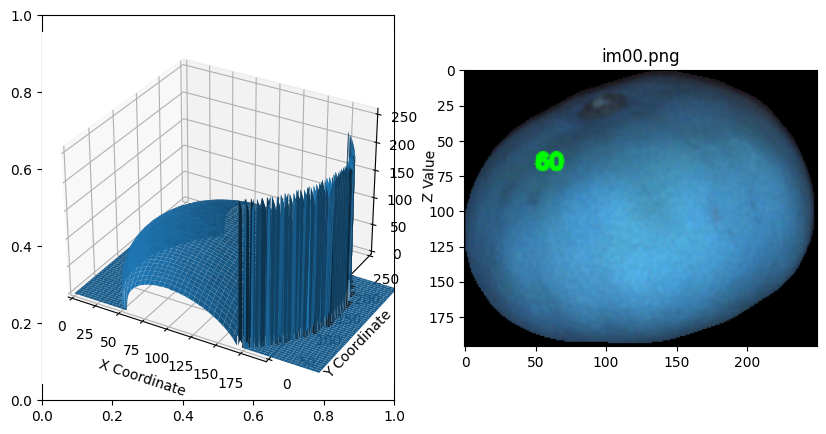

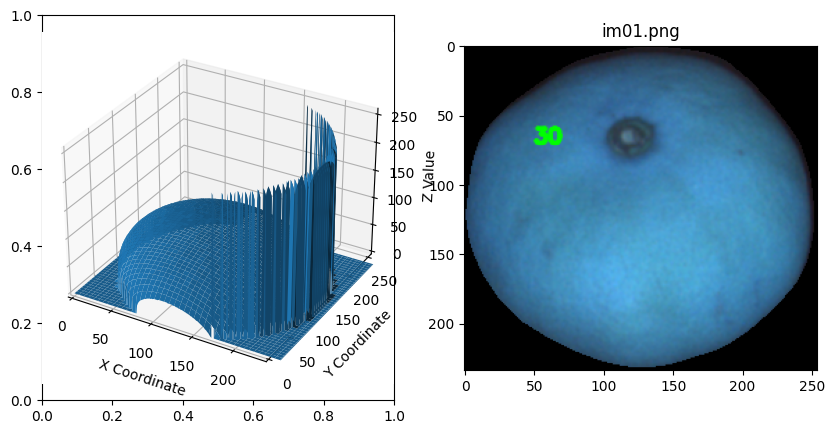

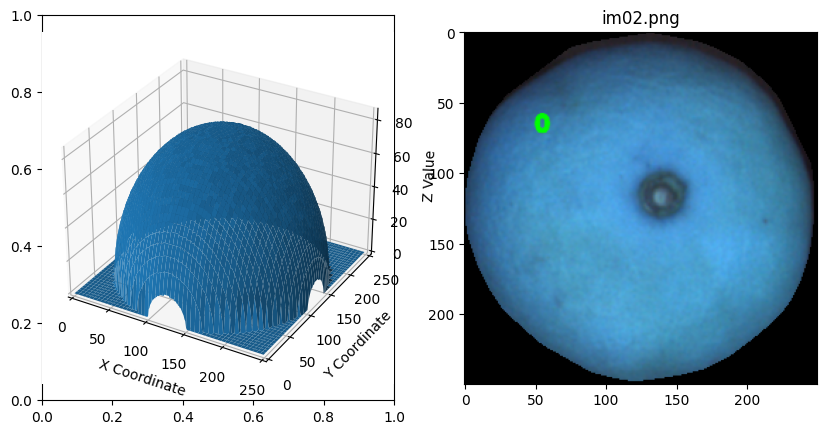

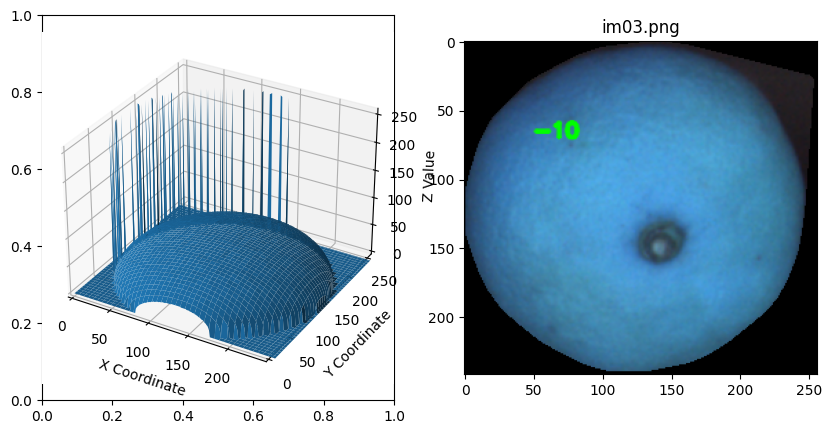

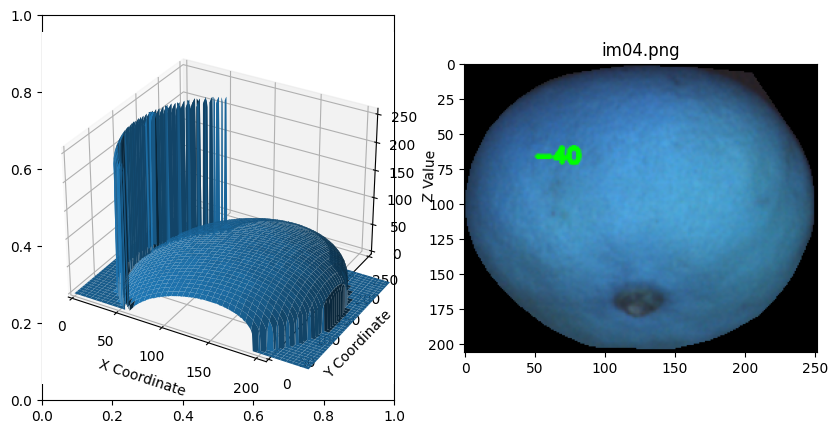

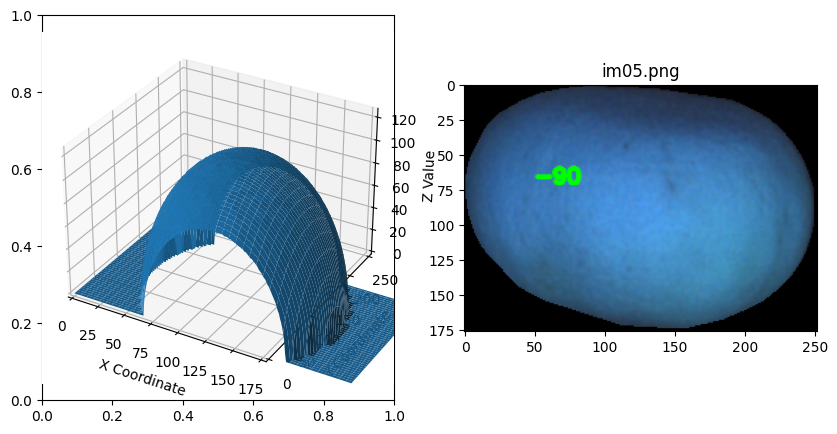

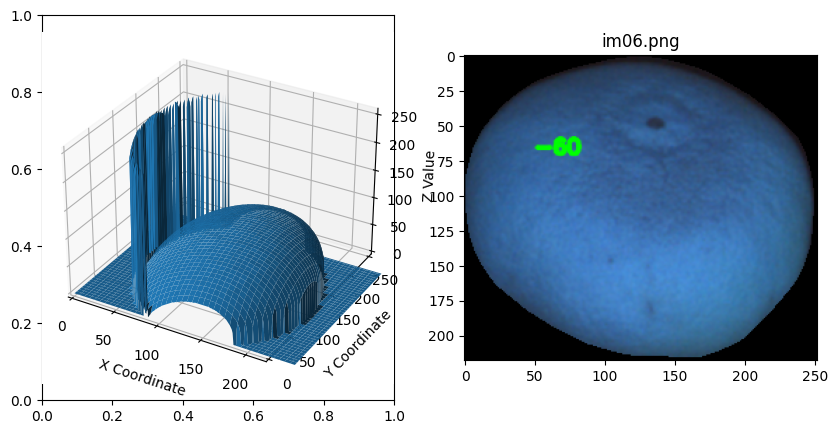

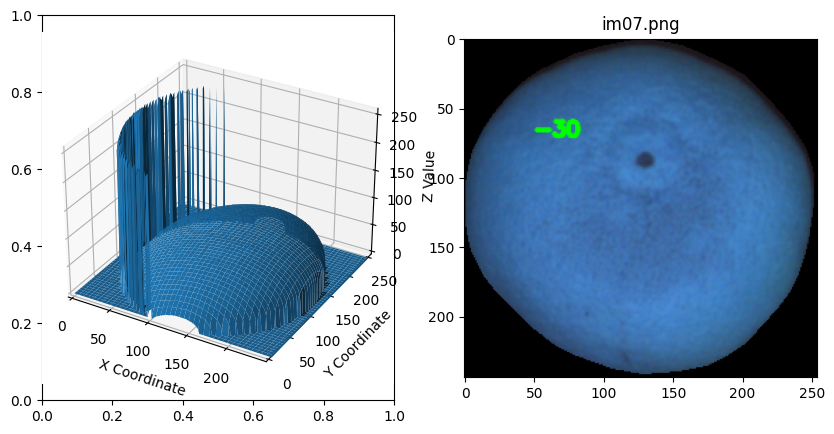

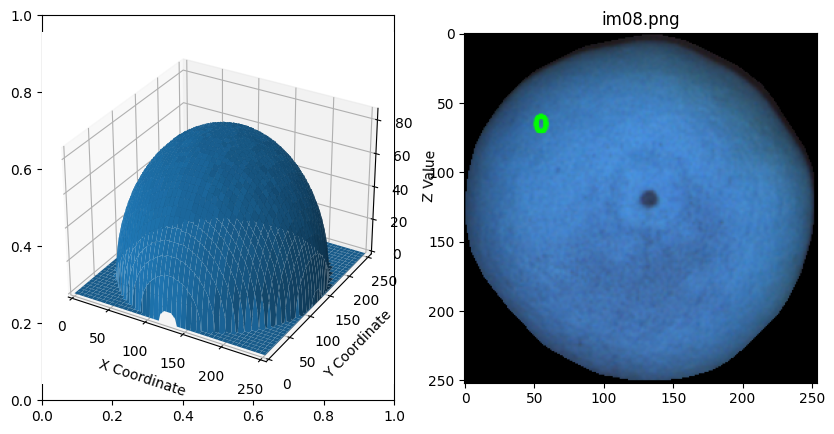

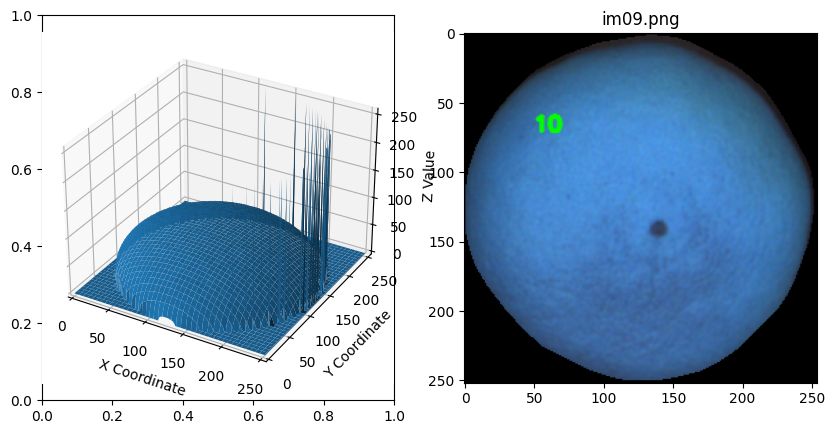

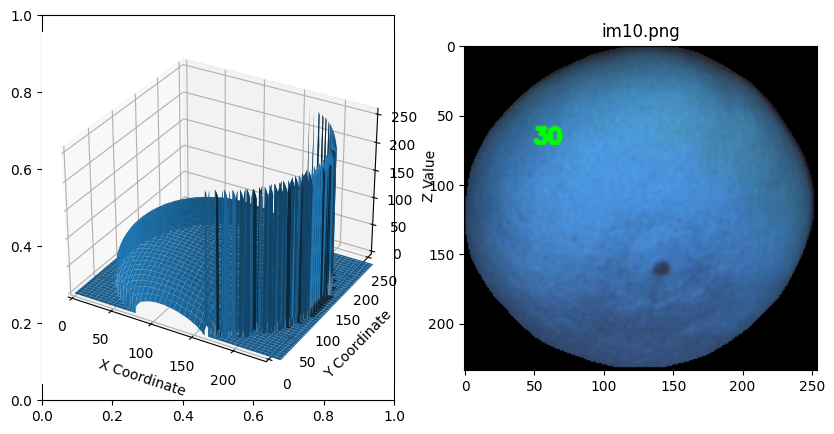

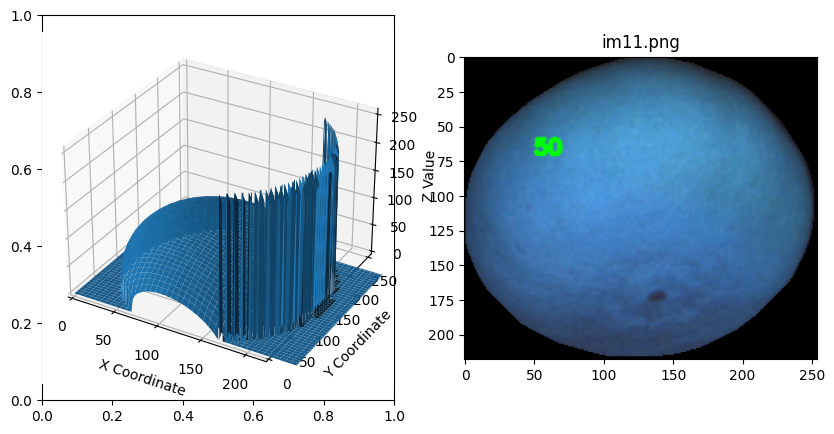

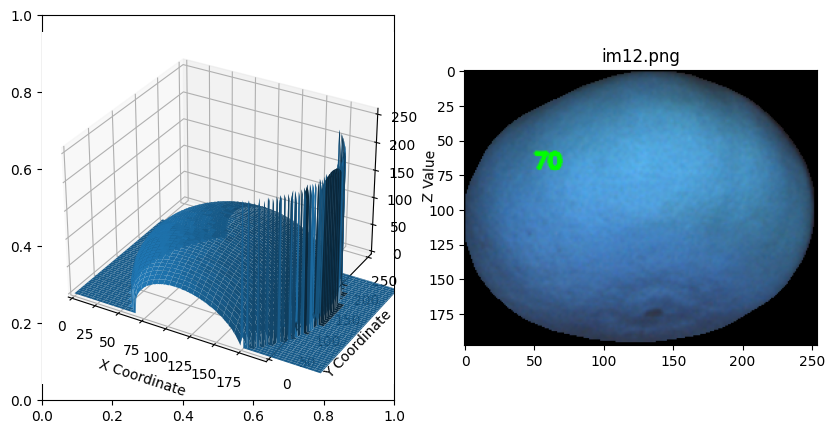

In [22]:
for index, view in enumerate(image_files):
  # img = cv2.imread(fruit_folder + view)
  img = images[index]
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  z_coordinates = z_coordinates_views_all[index]

  # Create X and Y coordinates
  y = np.arange(0, img.shape[0])
  x = np.arange(0, img.shape[1])
  X, Y = np.meshgrid(x, y)

  # Create a figure with 1 row and 2 columns
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))

  # Create a 3D surface plot on the first subplot
  axs[0] = fig.add_subplot(121, projection='3d')
  axs[0].set_xlim([0, img.shape[0]]) # width
  axs[0].set_ylim([0, img.shape[1]])

  axs[0].plot_surface(X, Y, z_coordinates)

  axs[0].set_xlabel('X Coordinate')
  axs[0].set_ylabel('Y Coordinate')
  axs[0].set_zlabel('Z Value')

  # Display the image on the second subplot
  axs[1].imshow(angle_images[index])
  axs[1].set_title(view)

  plt.show()
